# Amazon Automotive Reviews

This notebook's goal is to gain some insight into automotive product reviews from Amazon using text analytics. There's many ways to dive into these text reviews and the process below will touch on a handful that can share valuable insight. 

__Data:__ This dataset came from UCSD from Julian McAuley. It's a distribution of Amazon product reviews and metadata from about 142.8 million reviews collected from May 1996 through July 2014. I chose to use a subset of the data for the automotive category which included around 20,473 reviews. The dataset came in the form of json compressed with a snippet of code to load into python/pandas for analysis. 

http://jmcauley.ucsd.edu/data/amazon/

In [4]:
import pandas as pd
import json
import gzip
import spacy
import textacy
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score

from nltk.twitter.common import json2csv
from nltk import sent_tokenize, word_tokenize
from nltk.twitter import Twitter, TweetWriter, credsfromfile

import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [5]:
nlp = spacy.load('en')  # Spacy english model

### Data Loading

In [6]:
# Loading json file -- thank you http://jmcauley.ucsd.edu/data/amazon/
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/Users/brandon/Downloads/reviews_Automotive_5.json.gz')
print('Sample: ' + df.iloc[1]['reviewText'])

Sample: These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you would see at a chinese knock off shop like harbor freight for 30 bucks.


### Data Preprocessing

For certain methods it's best to normalize text data by removing stopwords, punctuation and handling the case. I added an additional column in the dataframe representing the cleaned review for later access. 

In [7]:
def clean_preprocess(doc):
    """ Function to clean and run the text pre-processing steps.
    1. Lowercase
    2. Punctuation
    3. Stopwords
    :param doc: string
    :returns: text
    """
    # Lowercase -- can be done in spacy doc object as doc.lower_
    doc = doc.lower()
    
    # Punctuation
    doc = textacy.preprocess.remove_punct(doc)
    
    # Stopwords (using spacy stopwords)
    doc = [w for w in doc.split(' ') if not w in spacy.en.STOP_WORDS]
    
    # Custom stopwords to remove
    rm = ['-PRON-']
    doc = [w for w in doc if not w in rm]
    
    string = ' '.join(doc).replace('\n\n',' ').replace('\n', ' ')
    return string

# Apply function to df 
df['cleaned_review'] = df.reviewText.apply(clean_preprocess)

### Analysis

First exploring this dataset there is 20,473 individual product reviews. The total word count is 1,726,879 words, with popular stopwords filtered out from the Spacy english model there was 907,982 words remaining. The cleaned word corpus exposed some frequent terms: "use", "car", "like", "good" and "great" which could indicate later on more positive sentiment within the reviews. 

In [8]:
# Overall stats
word_ct = len(df['reviewText'].str.cat().split())
stop_words_ct = len([i for i in df['reviewText'].str.cat().split() if i in spacy.en.STOP_WORDS])

print('Amount of Reviews: ' + str(len(df)))
print('Total Word Count: ' + str(word_ct))
print('Total Stop Words: ' + str(stop_words_ct))
print('Stop Words: ' + str(stop_words_ct/word_ct) + '% of words')

Amount of Reviews: 20473
Total Word Count: 1726879
Total Stop Words: 818897
Stop Words: 0.4742063572491182% of words


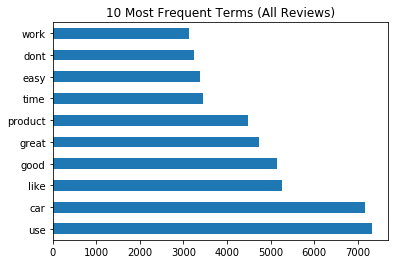

In [9]:
# Cleaned Reviews
pd.Series(df['cleaned_review'].str.cat()[:].split(' ')).value_counts()[1:11].plot(kind='barh', 
                                                                                 title='10 Most Frequent Terms (All Reviews)')

Wordcloud of all reviews (cleaned)


(-0.5, 399.5, 199.5, -0.5)

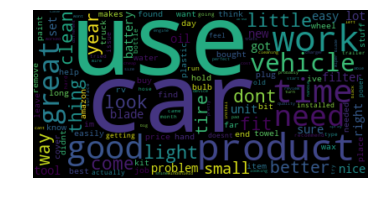

In [10]:
print('Wordcloud of all reviews (cleaned)')
wordcloud = WordCloud().generate(df['cleaned_review'].str.cat())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Natural Language Processing

Natural language processing can shed light into the format the reviews were written in. One of the immediate uses could be analysis of the parts of speech tagging. Below we look at verbs which are used to express actions or being might indicate how the product was used. Some of the interesting verbs were "need", "makes", "remove", "worked" and "found" - these could be the primary measures of the products being sold as tools where customers have a goal of completing some task. Some of the top nouns are "battery", "light", "oil" and "wiper" which could suggest the top sold products from Amazon in the sample. 

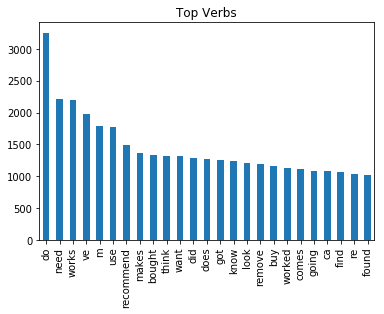

In [11]:
verb = []
doc = nlp(df['cleaned_review'].str.cat())
for token in doc:
    if token.pos_ == 'VERB':
        verb.append(token.text)
pd.Series(verb).value_counts()[:25].plot(kind='bar', title='Top Verbs')

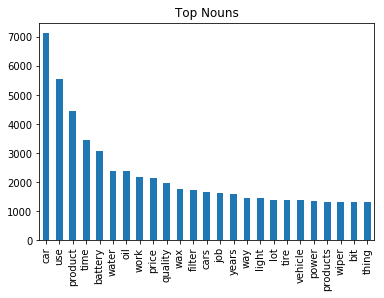

In [12]:
nouns = []
doc = nlp(df['cleaned_review'].str.cat())
for token in doc:
    if token.pos_ == 'NOUN':
        #print(token.pos_, token.text)
        nouns.append(token.text)
pd.Series(nouns).value_counts()[:25].plot(kind='bar', title='Top Nouns')

### Classification

Document classification can be useful when partitioning text into different associated categories. For this example I chose to train a supervised machine learning model (support vector machine) using the popular classification dataset, 20 newsgroups. I chose this as it already had interesting categories that may have overlap with our review data (ie autos and motorcycles). Interestingly majority of the predicted classes were in the autos classification followed by the motorcycles class. There was still a decent amount within the other classes but we shouldn't value much weight to those as the data samples built for the classifier and the review data are different. A great method to improve this classifier would be to use the assigned classes provided by the full dataset and retrain the model. This would be much more applicable to the full dataset and might actually be a QA/QC step for Amazon itself monitoring for appropriate reviews. 

In [13]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
vect = CountVectorizer().fit(newsgroups_train.data)  # Switch to TfidfVectorizer if time
X_train = vect.transform(newsgroups_train.data)  # Bag of words 
print('X_train Shape: ', X_train.shape)

# TF-IDF 
X_train_tfidf = TfidfTransformer().fit_transform(X_train)

X_train Shape:  (11314, 101631)


In [14]:
clf = SGDClassifier().fit(X_train_tfidf, newsgroups_train.target)
# auto data
x_auto = vect.transform(df['reviewText'])
x_auto = TfidfTransformer().fit_transform(x_auto)
pred = clf.predict(x_auto)

7 = Autos
8 = Motorcycles


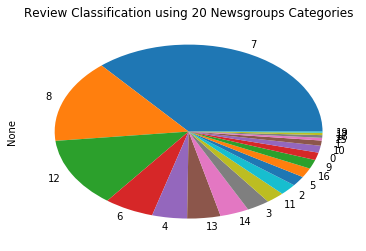

In [15]:
pd.Series(pred).value_counts().plot(kind='pie', title='Review Classification using 20 Newsgroups Categories') 
print('7 = Autos\n8 = Motorcycles')
df['class'] = pred  # add to df

### Clustering

Document clustering is another great method to group data, this one in particular usually tends to be more useful for data exploration as it's unsupervised. But it can provide very interesting information about the groupings it naturally found within the text. When performing a silhouette score to help us find interesting K values, it looks like the MiniBatchKmeans found an elbow around 4 clusters. One cluster found descriptive positive words for the products, another seemed to go more technical for the actual products, another related closer to car care products and the last was related to power and batteries. These could also indicate the types of products Amazon was catering to the most during the sample years. Majority of the words were clustered into the 3rd cluster (car care) which could indicate more items were being sold were things like car wash supplies and related products. 

In [16]:
tfidf_vector = TfidfVectorizer(stop_words='english')
x_data = tfidf_vector.fit_transform(df['cleaned_review'])

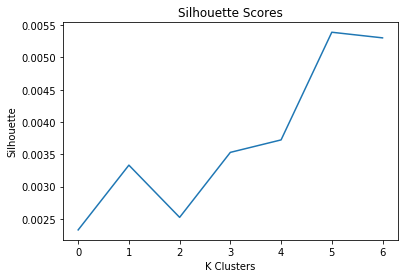

In [17]:
# Choosing K 
sil_scores = []

for n_clusters in range(2,9):
    k_mini = MiniBatchKMeans(n_clusters=n_clusters)
    k_mini.fit(x_data)
    
    labels = k_mini.labels_
    centr = k_mini.cluster_centers_
    # Need to use smaller sample size -- runs out of memory and crashes kernel
    sil_scores.append(silhouette_score(x_data, labels, metric='euclidean', sample_size=2000)) 

plt.plot(sil_scores)
plt.title('Silhouette Scores')
plt.ylabel('Silhouette')
plt.xlabel('K Clusters')
plt.show()

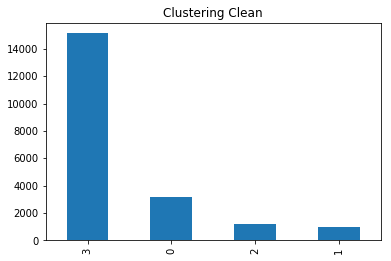

In [18]:
clf = KMeans(n_clusters=4)
labels = clf.fit(x_data)

df['cluster'] = labels.labels_
df['cluster'].value_counts().plot(kind='bar', title='Clustering Clean')

In [19]:
# Top terms per cluster
vocab_frame = pd.DataFrame({'words': tfidf_vector.get_feature_names()[:]}, 
                           index = tfidf_vector.get_feature_names()[:])

order_centroids = clf.cluster_centers_.argsort()[:, ::-1] 

for i in range(4):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :20]: 
        print(' %s' % vocab_frame.ix[tfidf_vector.get_feature_names()[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print('\n')

Cluster 0 words: b'car', b'wax', b'product', b'wash', b'use', b'great', b'leather', b'shine', b'good', b'like', b'towel', b'towels', b'microfiber', b'paint', b'clean', b'water', b'spray', b'products', b'meguiars', b'clay',

Cluster 1 words: b'battery', b'charger', b'tender', b'charge', b'batteries', b'power', b'use', b'charged', b'plug', b'unit', b'charging', b'car', b'motorcycle', b'works', b'great', b'time', b'solar', b'winter', b'need', b'dead',

Cluster 2 words: b'filter', b'oil', b'filters', b'change', b'kn', b'air', b'great', b'use', b'price', b'good', b'engine', b'cabin', b'fram', b'oem', b'quality', b'changes', b'better', b'car', b'buy', b'best',

Cluster 3 words: b'great', b'use', b'good', b'easy', b'works', b'like', b'product', b'work', b'fit', b'price', b'time', b'light', b'bought', b'dont', b'little', b'quality', b'nice', b'install', b'need', b'better',



### Sentiment  Analysis

For sentiment analysis this is using a logistic regression supervised machine learning model trained with the Large Movie Database reviews. Interestingly the predicted sentiment is more positive than negative. I feel that with some of the reviews being in a techical category like automotive it might be difficult to discern scarcasm or complex passages but from the spot-checking it seems to perform very well and the customers are more pleased than upset about their purchases. 

In [20]:
# Training data loading
reviews_train = load_files('/Users/brandon/data/aclImdb/train/')
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files('/Users/brandon/data/aclImdb/test/')
text_test, y_test = reviews_test.data, reviews_test.target

# Clean some of the HTML 
text_train = [doc.replace(b'<br />', b" ") for doc in text_train]
text_test = [doc.replace(b'<br />', b" ") for doc in text_test]

# Tf-idf and grid search for runing the logistic regression model
pipeline = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression())
parameters = {'logisticregression__C': [.001, .01, .1, 1, 10]}  # grid search

grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid.fit(text_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm=None, preprocessor=None, smooth_i...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [21]:
collection = df['reviewText'][:2]
p = grid.predict(collection)

for d, pred in zip(collection, p):
    print('%r \n>>> %s' % (d, pred))
    print()

"I needed a set of jumper cables for my new car and these had good reviews and were at a good price.  They have been used a few times already and do what they are supposed to - no complaints there.What I will say is that 12 feet really isn't an ideal length.  Sure, if you pull up front bumper to front bumper they are plenty long, but a lot of times you will be beside another car or can't get really close.  Because of this, I would recommend something a little longer than 12'.Great brand - get 16' version though." 
>>> 1

'These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you would see at a chinese knock off shop like harbor freight for 30 bucks.' 
>>> 0



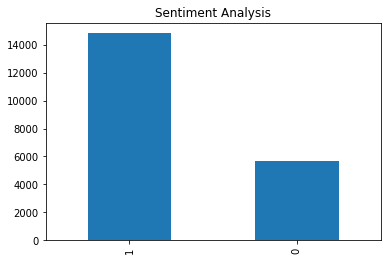

In [22]:
# Predict all 
df['sentiment'] = grid.predict(df['reviewText'])
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Analysis')

### Social Media Analysis

Social media analysis could be helpful for comparing review sentiment to tweets related to certain products. For the use case of this notebook we aren't looking for an individual product and comparing what users think of it. A good example might be looking at iPhone reviews on Amazon and comparing the sentiment with twitter posts related to the hashtag. I will include a snippet of code below that can illustrate how this could be incorporated.

In [23]:
tw = Twitter()
tw.tweets(keywords='#iphonex', stream=False, to_screen=False, limit=100)

Writing to /Users/brandon/twitter-files/tweets.20171213-212945.json
Written 100 Tweets


In [24]:
# convert to csv based on the text of the tweet
with open('/Users/brandon/twitter-files/tweets.20171212-215225.json') as fp:
    json2csv(fp, 'tweets_textv2.csv', ['text'])
    
# grab tweets in a list 
with open('tweets_textv2.csv', 'r') as f:
    tweets = f.readlines()

tweets = pd.read_csv('./tweets_textv2.csv', encoding='utf8')
print('Sample\n')
print(tweets.head(5))
print()

# Sentiment analysis - example
print('Example tweet:', tweets.iloc[9]['text'])
if grid.predict([tweets.iloc[9]['text']]) == 0:
    print('\nNegative Sentiment')
else:
    print('\nPositive Sentiment')

Sample

                                                text
0  RT @moment: Win an #iPhoneX and the greatest m...
1  #Win one of these #iPhoneX &amp;amp; #iPhone8 ...
2  Is it just me or has Christmas shopping become...
3  RT @moment: Win an #iPhoneX and the greatest m...
4  https://t.co/bmI8MWISls RT @techeblog: ss Char...

Example tweet: #iPhoneX review: Plus I seriously dont understand as to why there is so much of hatred towards the #Notch . Its muc… https://t.co/Me586ntHUf

Negative Sentiment


### Dataset

In [25]:
df.head(10)  # with updated predictions

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,cleaned_review,class,cluster,sentiment
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5.0,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011",needed set jumper cables new car good reviews ...,7,3,1
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4.0,Okay long cables,1315094400,"09 4, 2011",long cables work fine truck quality little sha...,8,3,0
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5.0,Looks and feels heavy Duty,1374710400,"07 25, 2013",cant comment come update review find issues us...,12,1,1
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5.0,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010",absolutley love amazon price set cheap booste...,12,1,0
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5.0,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012",purchased 12 feet long cable set arrived retai...,6,3,0
5,A1ORODEBRN64C,B00002243X,"James F. Magowan ""Jimmy Mac""","[1, 1]","These Jumper cables are heavy Duty, Yet easy t...",5.0,Compact and Strong !,1258156800,"11 14, 2009",jumper cables heavy duty easy store containers...,12,3,1
6,A2R49ZN3G6FTCQ,B00002243X,John M. Harrell,"[1, 1]",bought these for my k2500 suburban plenty of l...,5.0,nice cables,1326153600,"01 10, 2012",bought k2500 suburban plenty length rear ended...,8,1,1
7,A1Q65KYDKXIX8E,B00002243X,Leeland H.,"[0, 0]",these are good enough to get most motorized ve...,5.0,for cars and pickups,1371081600,"06 13, 2013",good motorized vehicles running semi farm equi...,12,3,1
8,A3BI8BKIHESDNQ,B00002243X,L. J. Cunningham,"[0, 0]",The Coleman Cable 08665 12-Feet Heavy-Duty Tru...,4.0,Coleman Cable 08665 12-Feet Heavy-Duty Truck a...,1374105600,"07 18, 2013",coleman cable 08665 12feet heavyduty truck aut...,8,3,0
9,A1R089P5AS26UE,B00002243X,Mike,"[0, 0]","I have an old car, Its bound to need these som...",5.0,Beefy,1390348800,"01 22, 2014",old car bound need got set gave old ones boss ...,7,3,0


### Findings 

It seems from the mining and analysis performed from the sample provided, Amazon was mostly selling products related to car care and battery-related goods. When looking over the NLP tags it appears most of the customers were mostly concerned with tools or products to get a job done or to generally work. Overall majority of the reviews were positive about the products. This information could provide Amazon with valuable insight into selling or promoting higher quality goods to be sold in the automotive section. If certain products have reviews or complaints about quality issues or things not functioning it's critically bad for the customers from this sample. Other interesting information that could be used by Amazon would be review clustering and classification. Methods like this could help automate quality control and assurance when it's not possible for humans to manually perform. This could help structure insights for reporting purposes as well as clean and organize the most helpful reviews for potential customers researching items. The methods above just start to crack the surface into what could be done using text analytics on datasets like this, there's many more optimizations and other methods that could be explored. 

### Resources

http://jmcauley.ucsd.edu/data/amazon/

https://spacy.io/usage/linguistic-features

https://github.com/brandonserna/Text-Analytics-Samples (all resources)

